# Libraries

In [1]:
#TODO: Write down all required libs

In [2]:
import pandas as pd
import numpy as np
import pvlib

In [3]:
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain

# Setup

In [4]:
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

In [5]:
spr_315 = sandia_modules['SunPower_SPR_315E_WHT__2007__E__']
sma_3000 = cec_inverters['SMA_America__SB3000TL_US_22__240V_']

In [6]:
#TODO: Add parameters
stuttgart = Location(latitude=48.77, longitude=9.18)

In [7]:
#NOTE: Too bad, this boilerplate code seems to be required
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

In [8]:
system = PVSystem(surface_tilt=30,
                  surface_azimuth=180,
                  module_parameters=spr_315,
                  inverter_parameters=sma_3000,
                  modules_per_string=10,
                  strings_per_inverter=1,
                  temperature_model_parameters=temperature_model_parameters
                 )

# Simulation

In [9]:
mc = ModelChain(system, stuttgart)

## Try to get weather from PVGIS

In [10]:
# Avoid downloading same data over and over again
import requests_cache
requests_cache.install_cache('pvgis_requests_cache', backend='sqlite')

In [11]:
weather, _, _, _ = pvlib.iotools.pvgis.get_pvgis_tmy(stuttgart.latitude, stuttgart.longitude)

In [12]:
weather

,T2m,RH,G(h),Gb(n),Gd(h),IR(h),WS10m,WD10m,SP
time(UTC),,,,,,,,,
2016-01-01 00:00:00+00:00,2.70,96.70,0.0,0.0,0.0,292.75,1.06,219.0,99358.0
2016-01-01 01:00:00+00:00,3.26,97.01,0.0,0.0,0.0,299.49,1.05,228.0,99374.0
2016-01-01 02:00:00+00:00,3.83,97.32,0.0,0.0,0.0,306.23,1.03,238.0,99390.0
2016-01-01 03:00:00+00:00,4.39,97.62,0.0,0.0,0.0,312.97,1.01,222.0,99383.0
2016-01-01 04:00:00+00:00,4.96,97.93,0.0,0.0,0.0,319.71,0.99,207.0,99377.0
...,...,...,...,...,...,...,...,...,...
2007-12-31 19:00:00+00:00,-0.12,95.16,0.0,0.0,0.0,259.05,1.16,248.0,99586.0
2007-12-31 20:00:00+00:00,0.45,95.47,0.0,0.0,0.0,265.79,1.14,246.0,99574.0
2007-12-31 21:00:00+00:00,1.01,95.78,0.0,0.0,0.0,272.53,1.12,248.0,99561.0


In [13]:
# Should wind be used?
weather = weather.rename(columns={'G(h)': 'ghi',
                                  'Gb(n)': 'dni',
                                  'Gd(h)': 'dhi',
                                  'T2m': 'temp_air'
                                 })

In [14]:
# TMY uses data from multiple years. For display purposes, it makes sense to move all the data to the same year. Same code as in pvlib.iotools.tmy#read_tmy3 coerce_year
coerce_year = 2019
weather['original_datetime'] = weather.index
weather.index = weather.index.map(lambda dt: dt.replace(year=coerce_year))

In [15]:
weather

,temp_air,RH,ghi,dni,dhi,IR(h),WS10m,WD10m,SP,original_datetime
time(UTC),,,,,,,,,,
2019-01-01 00:00:00+00:00,2.70,96.70,0.0,0.0,0.0,292.75,1.06,219.0,99358.0,2016-01-01 00:00:00+00:00
2019-01-01 01:00:00+00:00,3.26,97.01,0.0,0.0,0.0,299.49,1.05,228.0,99374.0,2016-01-01 01:00:00+00:00
2019-01-01 02:00:00+00:00,3.83,97.32,0.0,0.0,0.0,306.23,1.03,238.0,99390.0,2016-01-01 02:00:00+00:00
2019-01-01 03:00:00+00:00,4.39,97.62,0.0,0.0,0.0,312.97,1.01,222.0,99383.0,2016-01-01 03:00:00+00:00
2019-01-01 04:00:00+00:00,4.96,97.93,0.0,0.0,0.0,319.71,0.99,207.0,99377.0,2016-01-01 04:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+00:00,-0.12,95.16,0.0,0.0,0.0,259.05,1.16,248.0,99586.0,2007-12-31 19:00:00+00:00
2019-12-31 20:00:00+00:00,0.45,95.47,0.0,0.0,0.0,265.79,1.14,246.0,99574.0,2007-12-31 20:00:00+00:00
2019-12-31 21:00:00+00:00,1.01,95.78,0.0,0.0,0.0,272.53,1.12,248.0,99561.0,2007-12-31 21:00:00+00:00


In [16]:
#np.seterr(invalid='ignore')
mc.run_model(weather)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

In [17]:
type(weather)

pandas.core.frame.DataFrame

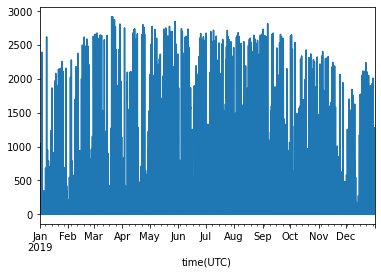

In [18]:
#NOTE: Should move to same year (coerce_year)
mc.ac.plot()

In [19]:
import matplotlib.pyplot as plt

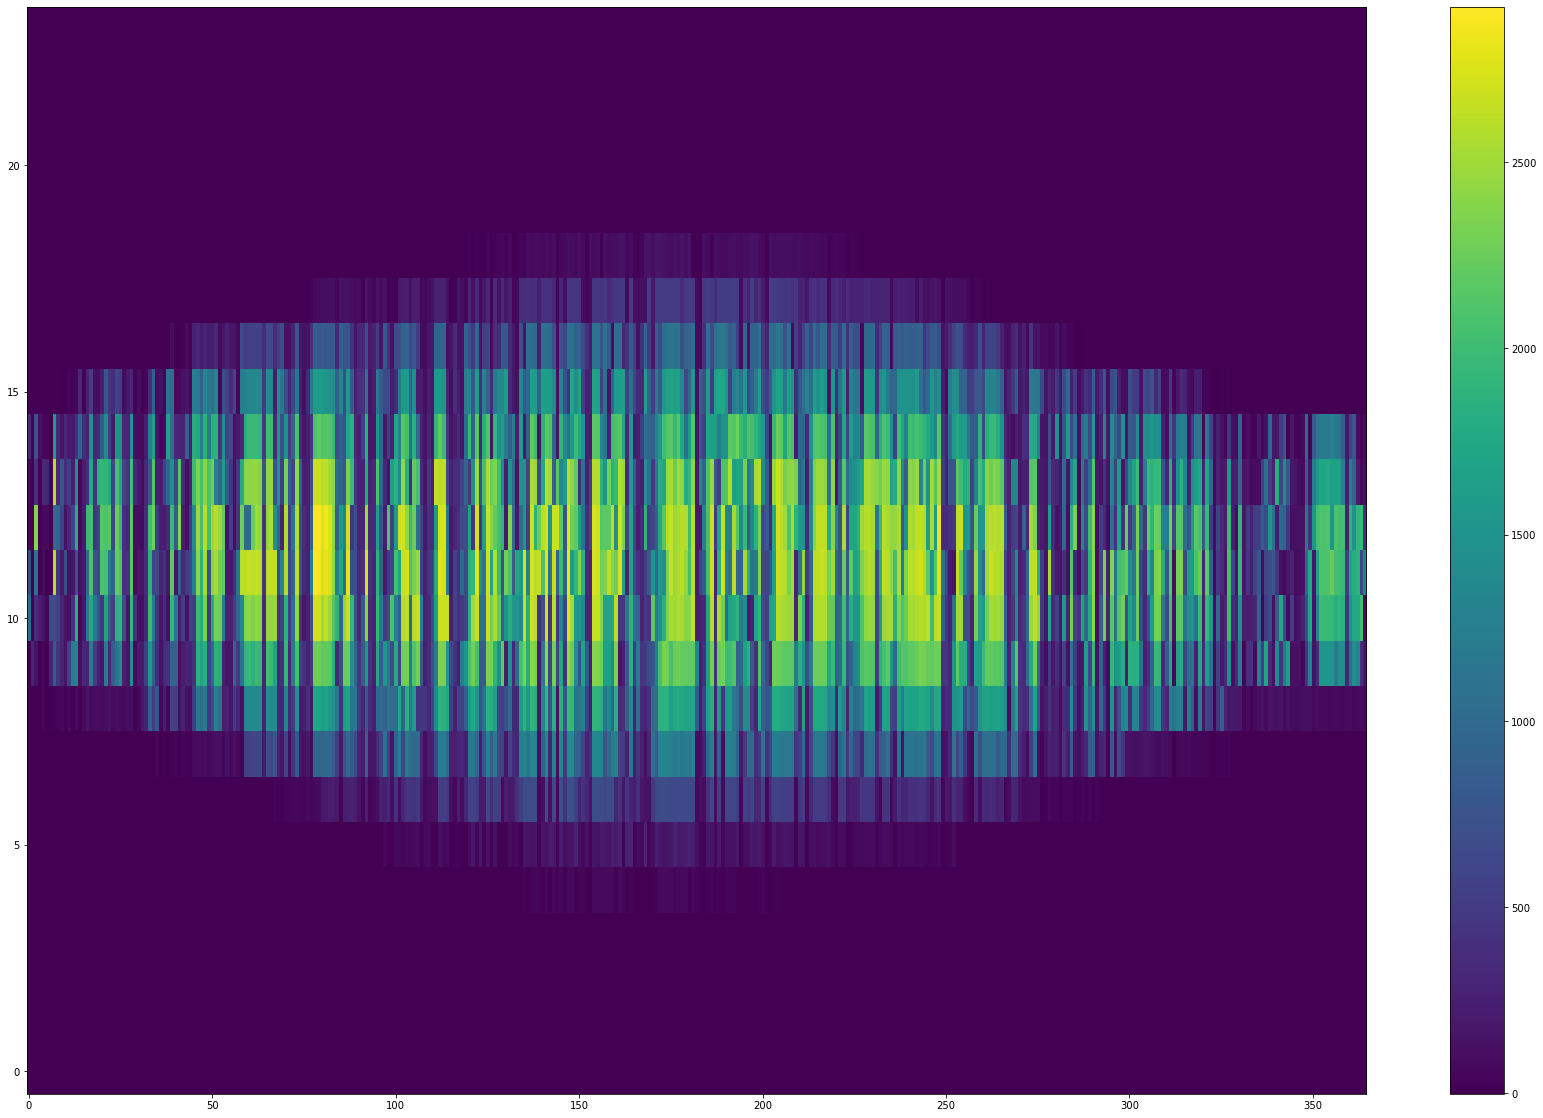

In [20]:
plt.figure(figsize=(30, 20))
plt.imshow(mc.ac.values.reshape(-1,24).T,
           aspect='auto',
           origin='lower'
          )
plt.colorbar()

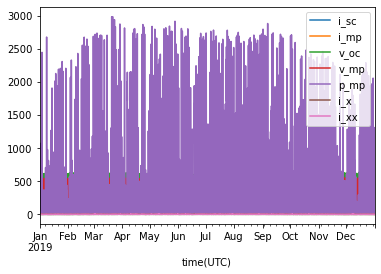

In [21]:
mc.dc.plot()

In [22]:
'Total Yield : %.0f kWh/a' % (mc.ac.sum() / 1000)

'Total Yield : 3882 kWh/a'

In [23]:
'Specific yield : %.0f kWh/kWp.a' % (mc.ac.sum() / (315 * 10) )

'Specific yield : 1232 kWh/kWp.a'

In [24]:
'Performace Ratio : %.1f %%' % ((mc.ac.sum() / (315 * 10) / (mc.total_irrad.poa_global.sum()/1000)) * 100)

'Performace Ratio : 90.2 %'

In [25]:
#TODO: Add Sankey because it looks cool

# Comparison with INSEL

In [26]:
#TODO: Fix INSEL call and compare to PVGIS + PVLIB

In [27]:
import insel

In [28]:
stuttgart_weather = pd.DataFrame(insel.template('pvlib_weather_generation'), index=localized_one_year, columns=['wind_speed', 'temp_air', 'dni', 'ghi', 'dhi'])

NameError: name 'localized_one_year' is not defined

In [ ]:
stuttgart_weather.ghi.sum() / 1000

In [ ]:
mc.run_model(localized_one_year, stuttgart_weather)

In [ ]:
'Specific yield : %.0f kWh/kWp.a' % (mc.ac.sum() / (315 * 10) )

In [ ]:
'Global tilted irradiance : %.0f kWh/m².a' % (mc.total_irrad.poa_global.sum()/1000)

In [ ]:
'Performace Ratio : %.1f %%' % ((mc.ac.sum() / (315 * 10) / (mc.total_irrad.poa_global.sum()/1000)) * 100)

# Module IV curve

In [ ]:
#TODO: Model own PV module, e.g. any recent half cell module

In [ ]:
type(spr_315)

In [ ]:
mc.dc_model

In [ ]:
spr_315_5_points = pvlib.pvsystem.sapm(1, # WARNING: Effective irradiance! 1 sun = 1000W/m²
                    25,
                    spr_315)

In [ ]:
def sapm_to_ivframe(sapm_row):
    pnt = sapm_row

    ivframe = {'Isc': (pnt['i_sc'], 0),
              'Pmp': (pnt['i_mp'], pnt['v_mp']),
              'Ix': (pnt['i_x'], 0.5*pnt['v_oc']),
              'Ixx': (pnt['i_xx'], 0.5*(pnt['v_oc']+pnt['v_mp'])),
              'Voc': (0, pnt['v_oc'])}
    ivframe = pd.DataFrame(ivframe, index=['current', 'voltage']).T
    ivframe = ivframe.sort_values(by='voltage')
    
    return ivframe

def ivframe_to_ivcurve(ivframe, points=100):
    ivfit_coefs = np.polyfit(ivframe['voltage'], ivframe['current'], 30)
    fit_voltages = np.linspace(0, ivframe.loc['Voc', 'voltage'], points)
    fit_currents = np.polyval(ivfit_coefs, fit_voltages)
    
    return fit_voltages, fit_currents

In [ ]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)


iv_frame = sapm_to_ivframe(spr_315_5_points)
fit_voltages, fit_currents = ivframe_to_ivcurve(iv_frame)

import matplotlib.pyplot as plt
plt.plot(fit_voltages, fit_currents)
plt.plot(iv_frame['voltage'], iv_frame['current'], 'ko')
plt.title('Sunpower 315 at STC (Graph looks wrong!)')
plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.plot()